In [4]:
%cd /Users/edoardorossi/Documents/GitHub/Last_tesi
PROJECT_PATH = '/Users/edoardorossi/Documents/GitHub/Last_tesi'
CTA30_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os
sys.path.insert(0, os.path.abspath('functions'))
sys.path.insert(0, os.path.abspath(''))
warnings.filterwarnings('ignore')
#from functions.pkl import store_data, load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.optimize import differential_evolution
import random
from collections import defaultdict
import time
import itertools
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def store_data(data, file_name):
    dbfile = open(file_name, 'ab')
    pickle.dump(data, dbfile)
    dbfile.close()
  
def load_data(file_name):
    dbfile = open(file_name, 'rb')
    db = pickle.load(dbfile)
    dbfile.close()
    return db

/Users/edoardorossi/Documents/GitHub/Last_tesi


In [2]:
cta30_def_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')  
df_def = pd.read_csv(cta30_def_path)

try:
    df = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df.csv'))
    df_a = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_a.csv'))
    df_rew = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_rew.csv')) 
    
except:
    cta30_18_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
    cta30_19_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
    cta30_20_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
    cta30_21_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
    cta30_22_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')

    df18= pd.read_csv(cta30_18_path)
    df19= pd.read_csv(cta30_19_path)
    df20= pd.read_csv(cta30_20_path)
    df21= pd.read_csv(cta30_21_path)
    df22= pd.read_csv(cta30_22_path)

    df_complete = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

    #drop le colonne 'F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00' 
    df = df_complete.drop(['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00'], axis=1)
    # create df_a with only dropped columns
    df_a = df_complete[['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00']]


    df_a['VLV_RAF_REG_00'] = df_a['VLV_RAF_REG_00'].apply(lambda x: 1 if x>=0.5 else 0)
    df_a['VLV_SUR_REG_00'] = df_a['VLV_SUR_REG_00'].apply(lambda x: 1 if x>=0.5 else 0)

    df_a['VLV'] = 0 # colonna inizializzata a 0
    for i in range(len(df)):
        if df_a['VLV_RAF_REG_00'][i] == 0 and df_a['VLV_SUR_REG_00'][i] == 0:
            df_a.loc[i, 'VLV'] = 0
        elif df_a['VLV_RAF_REG_00'][i] == 0 and df_a['VLV_SUR_REG_00'][i] != 0:
            df_a.loc[i, 'VLV'] = -1
        elif df_a['VLV_RAF_REG_00'][i] != 0 and df_a['VLV_SUR_REG_00'][i] == 0:
            df_a.loc[i, 'VLV'] = 1

    df_a = df_a.drop(['VLV_RAF_REG_00', 'VLV_SUR_REG_00'], axis=1)

    df_rew = df_complete[['T_AMB_00', 'T_AMB_01', 'T_AMB_02', 'T_AMB_03', 'PW_ATT_M_00', 'T_M_SP_00']]

    #df_rew.to_csv(os.path.join(PROJECT_PATH, 'df_rew.csv'), index=False)     

    #print shapes of df and df_a and df_rew
    print('df shape: ', df.shape)
    print('df_a shape: ', df_a.shape)
    print('df_rew shape: ', df_rew.shape)

    df.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df.csv'), index=False)
    df_a.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_a.csv'), index=False)
    df_rew.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_rew.csv'), index=False)




In [3]:
path_scale_norm ='DQN_data/scaler_norm.pkl'
scaler_path = os.path.join(PROJECT_PATH, path_scale_norm)
print(scaler_path)
try: 
    scale_norm = load_data(scaler_path)
    df_norm = pd.DataFrame(scale_norm.transform(df), columns=df.columns)
    print("Normalization loaded")
except:
    print("Computing normalization")
    scale_norm = MinMaxScaler()
    df_norm = pd.DataFrame(scale_norm.fit_transform(df), columns=df.columns)
    store_data(scale_norm, scaler_path)

print("The dataset has", df_norm.shape[1], "columns after normalization")

path_pca_norm = 'DQN_data/pca_norm.pkl'
pca_model_path = os.path.join(PROJECT_PATH, path_pca_norm)
print(pca_model_path)
try:
    pca = load_data(pca_model_path)
    pca_norm = pd.DataFrame(pca.transform(df_norm))
    print("PCA loaded")
except:
    print("Computing PCA")
    pca = PCA(n_components=0.9)
    pca_norm = pd.DataFrame(pca.fit_transform(df_norm))
    store_data(pca, pca_model_path)
    print("PCA computed")
print("The dataset has", pca_norm.shape[1], "columns after PCA")

df_a_norm = pd.DataFrame(scale_norm.fit_transform(df_a), columns=df_a.columns)




/Users/edoardorossi/Documents/GitHub/Last_tesi/DQN_data/scaler_norm.pkl
Computing normalization
The dataset has 73 columns after normalization
/Users/edoardorossi/Documents/GitHub/Last_tesi/DQN_data/pca_norm.pkl
PCA loaded
The dataset has 7 columns after PCA


In [ ]:
##################### FUNZIONI #####################

def state_reward(state):
    return -state['PW_ATT_M_00']

def cumulated_reward(reward_array):
    for i in range(len(reward_array)):
        if i == 0:
            reward_array[i] = reward_array[i]
        else:
            reward_array[i] = reward_array[i] + reward_array[i-1]
    return reward_array

def pred_best_q_next(next_state, action_set, model):
        best_action = maximization(next_state, action_set, model)
        s_a = state_action(next_state, best_action)
        q_next_ba = q_torch_predict(s_a, model)
        return q_next_ba

def state_action(state, action):
    state = state.to_numpy().reshape(1,-1) 
    action = action.to_numpy().reshape(1,-1)
    actions_df = pd.DataFrame(action, columns=['action_1', 'action_2'])
    state_df = pd.DataFrame(state, columns=df_norm.columns)
    s_a = pd.concat([state_df, actions_df], axis=1).to_numpy()
    s_a = torch.from_numpy(s_a).float()
    return s_a

def objective(next_state, x, model):
    s_a = state_action(next_state, x)
    q_next = q_torch_predict(s_a, model)   
    return q_next

def maximization(state, action_set, model):
    len_a1 = 4
    len_a2 = 3
    max_q = float('-inf')
    best_action = pd.Series([0,0])
    for i in range(len_a1):
        for j in range(len_a2):
            a0 = action_set[i][0][0]
            a1 = action_set[j][1]
            x0 = pd.Series([a0,a1])
            res = objective(state, x0, model)
            if res > max_q:
                max_q = res
                best_action = x0
                
    return best_action

def pred_best_q_next(next_state, action_set, model):
        best_action = maximization(next_state, action_set, model)
        s_a = state_action(next_state, best_action)
        q_next_ba = q_torch_predict(s_a, model)
        return q_next_ba



def q_torch_predict(s_a, model):
    model.eval() 
    with torch.no_grad():
        y_pred = model(s_a)
        q_ = y_pred.item()  
    return q_


##################### PARAEMTRI #####################

my_df = df_norm.copy()
my_actions_df = df_a_norm.copy()

r,c = df_a_norm.shape

# action space composition

f_clusterig_path = 'DQN_data/action_f_fit_norm'
folder_path = os.path.join(PROJECT_PATH, f_clusterig_path)
elbow = 4
try:
    with open(os.path.join(folder_path, 'kmeans_4.pkl'), 'rb') as f:
        action_f_model = pickle.load(f)
    print('action_f_model loaded')
except:
    X = my_actions_df['F_M_FDBK_00'].values.reshape(-1,1)
    action_f_model = KMeans(n_clusters=elbow, init='k-means++', max_iter=300, n_init=10, random_state=0)
    action_f_model.fit(X)
    with open(os.path.join(folder_path, 'kmeans_4.pkl'), 'wb') as f:
        pickle.dump(action_f_model, f)
    print('action_f_model computed')
F_M_centroids = action_f_model.cluster_centers_

vlv_values = my_actions_df['VLV'].unique()
action_set = list(itertools.product(F_M_centroids, vlv_values))

##################### RETE NEURALE ##################

class LogSumExp_NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LogSumExp_NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act1 = ExpActivation()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.act2 = LogActivation()

        self.layers.append(self.fc1)
        self.layers.append(self.fc2)
    
    
    def forward(self, x, T=1e-1):

        psi = self.compute_psi(x)

        x = self.fc1(x)
        x = self.act1((x - psi)/T)
        x = self.fc2(x)
        x = T*self.act2(x) + psi*T
        return x

    def compute_psi(self, x, T=1e-1):

        psi_values = []
        for layer in self.layers:
            x = layer(x)/T
            psi_values.append(x)
        assert len(psi_values) == len(self.layers)
        psi_float_values = []
        for tensor in psi_values:
            psi_float_values.extend(tensor.flatten().tolist())
        psi = max(psi_float_values)
        return psi


class ExpActivation(torch.nn.Module):
    def __init__(self):
        super(ExpActivation, self).__init__()
        
    def forward(self, x):
        return torch.exp(x)
    
class LogActivation(torch.nn.Module):
    def __init__(self):
        super(LogActivation, self).__init__()
    
    def forward(self, x):
        return torch.log(torch.exp(x))
    

state_size = my_df.shape[1]
input_size = state_size + 2
hidden_size = 15
output_size = 1

model = LogSumExp_NeuralNetwork(input_size, hidden_size, output_size)
model_path = 'DQN_data/NN_model_torch_av_re/torch_model_15.pth'
model_weights_path = os.path.join(PROJECT_PATH, model_path)
model_weights = torch.load(model_weights_path)
model.load_state_dict(model_weights)

##################### PREVISIONE ####################

my_df = df_norm.copy()
my_actions_df = df_a_norm.copy()

r,c = my_df.shape

simetria_f = my_actions_df['F_M_FDBK_00']
simetria_v = my_actions_df['VLV']
simetria_reward = cumulated_reward(state_reward(my_df))

my_f = np.zeros((r,1))
my_v = np.zeros((r,1))
reward = np.zeros((r,1))
my_reward = np.zeros((r,1))

time_axis = np.arange(0,r,1)



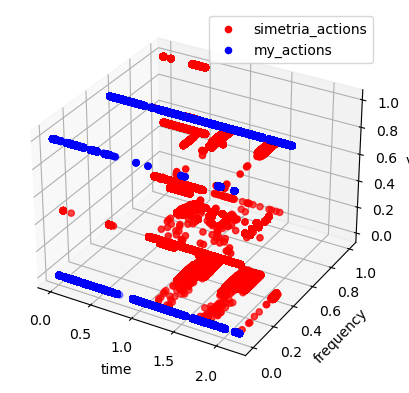

In [11]:


for data_idx in range(r-1):

    state = my_df.iloc[data_idx]
    next_state = my_df.iloc[data_idx+1]

    reward[data_idx] = state_reward(my_df.iloc[data_idx])
    best_actions = maximization(next_state, action_set, model)

    my_f[data_idx] = best_actions[0]
    my_v[data_idx] = best_actions[1]

#plot in a 3d graph simetria_f, simetria_v, time_axis

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(time_axis, simetria_f, simetria_v, c='r')
ax.scatter(time_axis, my_f, my_v, c='b')
ax.set_xlabel('time')
ax.set_ylabel('frequency')
ax.set_zlabel('vlv')
plt.legend(['simetria_actions', 'my_actions'])
plt.show()





In [ ]:
# save my_f, my_v, reward in a csv file
my_results = pd.DataFrame(np.concatenate((my_f, my_v, reward), axis=1), columns=['F_M_FDBK_00', 'VLV', 'reward'])
